# Object Classification

[Image Classification](https://en.wikipedia.org/wiki/Computer_vision#Recognition) (or Image Identification) is one of the pilot use cases for deep learning. The goal of the task is to train a model capable of identifying the main object of interest in an image. *What can you use it for?* Here are a few ideas - [identify landmarks in photos](https://ai.googleblog.com/2018/03/google-landmarks-new-dataset-and.html), [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), identifying celebrities (or yourself) in images, detecting anomalies in medical images.

### Dog Breed Classification

In this notebook, we will build a model to identify dog breeds in an image. How well you can tell your Norfolk Terriers from your Norwich Terriers? 

<img src="https://raw.githubusercontent.com/floydhub/image-classification-template/master/images/classification.png" width="500" height="500" align="center"/>

We will use the [Kaggle's Dog Breed Dataset](https://www.kaggle.com/c/dog-breed-identification) dataset for training. With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated. 

To speed things up, we will apply [Transfer Learning](https://cs231n.github.io/transfer-learning/) by [building new layers on top of the Xception model]( https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/mode) pre-trained on ImageNet to classify the top 10 dog breeds. *Note: We have reduced the number of classes (i.e. dog breeds) to 10 to fit the model in a CPU machine.*

We will:
- Preprocess images data for computer vision tasks
- Transfer Learning: build new layers on top of the pretrained Xception model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on new dog images from the web!


###  Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome image classification task.*

Now, let's get started! 🚀

## Initial Setup

Let's start by importing some packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

## Training Parameters

Here we define the hyperparameters for training our model. We recommend keeping the defaults for your first run 🙂

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 16  # Number of images used in each iteration
    EPOCHS = 3  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 1

## Data

The dog-breed dataset is already attached to your workspace. It should be available at `/floyd/input/dogbreed`. (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

*Note:* We set the `NUM_CLASSES` variable to 10 to keep only the Top 10 dog breeds (so you can train the model on a CPU machine in a reasonable time). Feel free to increase this if you're trying this on a GPU!

In [3]:
# Keep only the first 10 classes
NUM_CLASSES = 10 

data_dir = '/floyd/input/dogbreed/' # ADD path/to/dataset
labels = pd.read_csv(join(data_dir, 'labels.csv')) # EDIT WITH YOUR LABELS FILE NAME
print("Total number of images in the dataset: {}".format(len(listdir(join(data_dir, 'train'))))) 

print("Top {} labels (sorted by number of samples)".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)

Total number of images in the dataset: 10222
Top 10 labels (sorted by number of samples)


,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


### Transfer learning and data augmentation

This is the list of the top labels(dog breeds) sorted by the number of available samples in the dataset. If you notice, we only have ~100 examples of each breed - not much to train a deep learning model from scratch. 

Since we have only a few samples per label, we will
- Set up a Transfer Learning task using the Xception model (pre-trained on ImageNet)
- Use [data augmentation](https://en.wikipedia.org/wiki/Convolutional_neural_network#Artificial_data) to artificially increase the number of training images. We do this by manipulating (scaling, zooming, rotating, etc.) the input images.

Here is an example of what data augmentation does

Using TensorFlow backend.


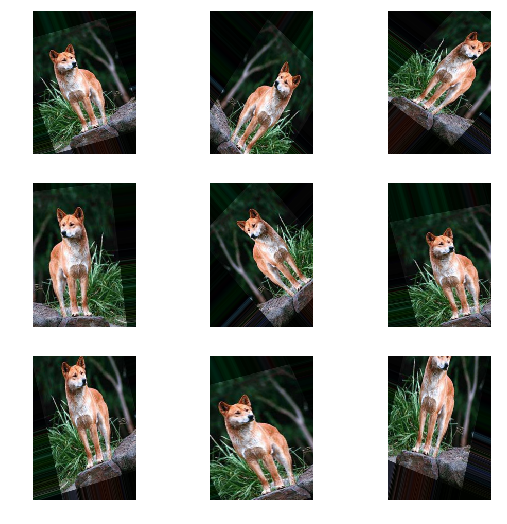

In [4]:
from support import data_augmentation_example

input_path = '/floyd/input/dogbreed/train/00a338a92e4e7bf543340dc849230e75.jpg' # An example image from the dataset
count = 9 # Number of samples to show

data_augmentation_example(input_path, count)

## Train - Val Split

We split the dataset into two sets, one for training and one for validation. Splitting the dataset is a common step when the validation and/or test sets are not provided.

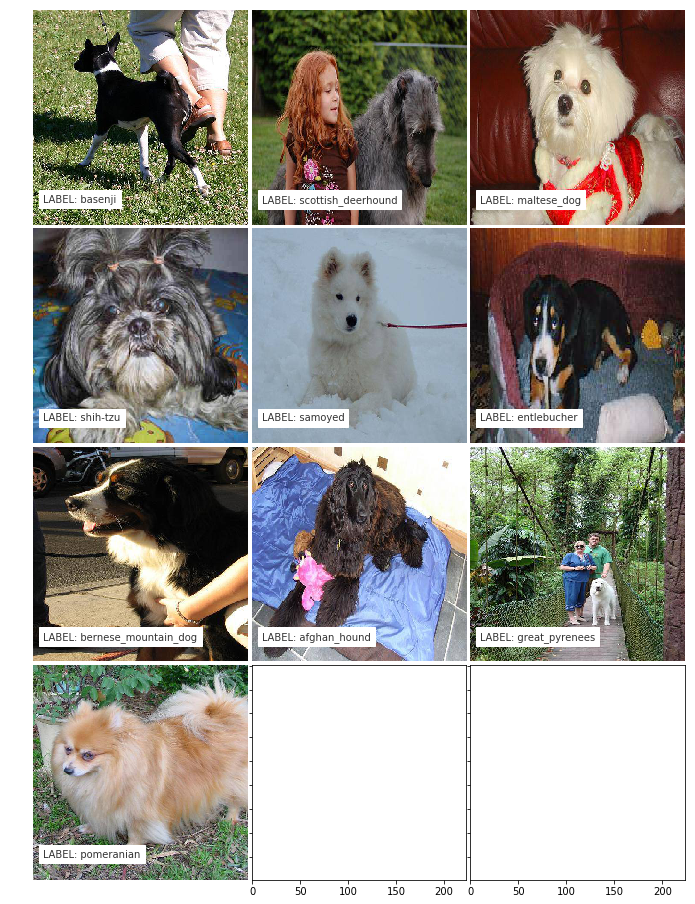

In [5]:
from support import split_train_val

# Make sure to have the same split
SEED = 2018

(train_idx, valid_idx, ytr, yv, labels, selected_breed_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)

from keras.preprocessing import image
from support import show_images

show_images(NUM_CLASSES, labels, data_dir)

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the images.

- The `xception.preprocess_input` method will normalize the value of each pixel to a number between -1 and 1, sample-wise.
- Data augmentation: The `ImageDataGenerator` class will apply the distortions (defined by the parameters) *during* the training process. 

**Note:**: Be careful with data augmentation - the agumentation step is done during the training process and it could [become a bottleneck in the input data pipeline](https://www.tensorflow.org/performance/datasets_performance) if the CPU is not fast enough to provide the preprocessed/augmented data for GPU computation.

In [6]:
# DATA LOADER
from keras.applications import xception
from support import read_img

INPUT_SIZE = 299 # width/height of image in pixels (as expected by Xception model)

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('\nTotal Images shape: {}'.format(x_train.shape))

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape, 
      '\n\nTrain samples (images, labels)', ytr.shape,
      '\nValidation samples (images, labels)', yv.shape)

# Data Loader
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

1141it [00:08, 129.85it/s]



Total Images shape: (1141, 299, 299, 3)
Train (images, H, W, C): (887, 299, 299, 3) 
Val (images, H, W, C): (254, 299, 299, 3) 

Train samples (images, labels) (887, 10) 
Validation samples (images, labels) (254, 10)


## Model definition

To speed things up, we will apply Transfer Learning by building new layers on top of the pre-trained [Xception](https://arxiv.org/abs/1610.02357) model. 

<img src="https://raw.githubusercontent.com/floydhub/image-classification-template/master/images/xception.png" width="600" height="600" align="center"/>

*Image from the [paper](https://arxiv.org/abs/1610.02357)*

In [7]:
### MODEL - BOTTLENECK FEATURES - OPTMIZER

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# Download and create the pre-trained Xception model for transfer learning
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## Train CNN model

If you left the default hyperpameters in the Notebook untouched, your training should take approximately:

- On CPU machine: 15-20 minutes for 1 epoch.
- On GPU machine: 1 minute for 3 epochs (*soo much faster*).

You should get an accuracy of > 96% on the validation set. *Note*: The model will start overfitting after 2 to 3 epochs, since we're already starting from a pre-trained Xception model.

In [8]:
# TRAINING
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE,
                           verbose=2)

Epoch 1/3
55/55 [==============================] - 26s 472ms/step - loss: 0.5806 - acc: 0.8101 - val_loss: 0.0378 - val_acc: 0.9917
Epoch 2/3
55/55 [==============================] - 24s 433ms/step - loss: 0.3408 - acc: 0.9000 - val_loss: 0.1463 - val_acc: 0.9542
Epoch 3/3
55/55 [==============================] - 24s 430ms/step - loss: 0.3208 - acc: 0.9125 - val_loss: 0.0786 - val_acc: 0.9708


## Evaluate on validation set

In [9]:
# EVAL
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen)

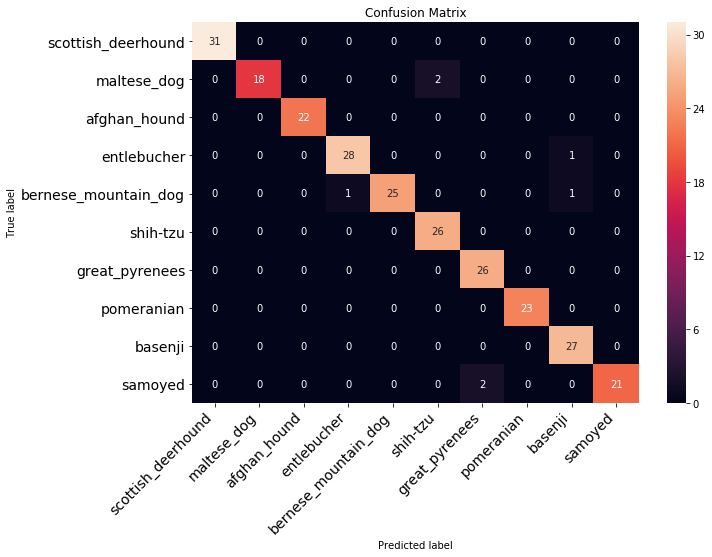

In [10]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities,axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

In [11]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

                      precision    recall  f1-score   support

  scottish_deerhound       1.00      1.00      1.00        31
         maltese_dog       1.00      0.90      0.95        20
        afghan_hound       1.00      1.00      1.00        22
         entlebucher       0.97      0.97      0.97        29
bernese_mountain_dog       1.00      0.93      0.96        27
            shih-tzu       0.93      1.00      0.96        26
      great_pyrenees       0.93      1.00      0.96        26
          pomeranian       1.00      1.00      1.00        23
             basenji       0.93      1.00      0.96        27
             samoyed       1.00      0.91      0.95        23

         avg / total       0.97      0.97      0.97       254



## It's your turn

Test out the model you just trained. Run the code Cell below and enter a URL with your favorite dog pic in the widget below. Have fun!🎉

*Note*: By default, only the top 10 dog breeds available.

Here are some URLs to test:

- Bernese: https://cdn.pixabay.com/photo/2016/02/06/19/18/dog-1183475_960_720.jpg
- Shih-tzu: https://cdn.pixabay.com/photo/2016/10/08/11/21/shih-tzu-puppy-1723492_960_720.jpg
- Samoyed: https://cdn.pixabay.com/photo/2017/06/14/00/59/samoyed-2400687_960_720.jpg

Can you do better? Play around with the model hyperparameters!

In [12]:
# Testing on url images
from support import prediction_from_url
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(URL):
    prediction_from_url(URL, model, selected_breed_list)

interact_manual(get_prediction, URL=widgets.Text(placeholder='Insert URL with a dog pic'));

interactive(children=(Text(value='', description='URL', placeholder='Insert URL with a dog pic'), Button(descr…

## Save the result

In [13]:
# Saving Model Weight
model.save_weights('models/tl_xception_weights.h5')

#### That's all folks - don't forget to shutdown your workspace once you're done 🙂